In [1]:
%matplotlib inline


# Face completion with a multi-output estimators


This example shows the use of multi-output estimator to complete images.
The goal is to predict the lower half of a face given its upper half.

The first column of images shows true faces. The next columns illustrate
how extremely randomized trees, linear regression, ridge regression,
and k nearest neighbors with or without hubness reduction
complete the lower half of those faces.


Adapted from https://scikit-learn.org/stable/auto_examples/plot_multioutput_face_completion.html

Automatically created module for IPython interactive environment


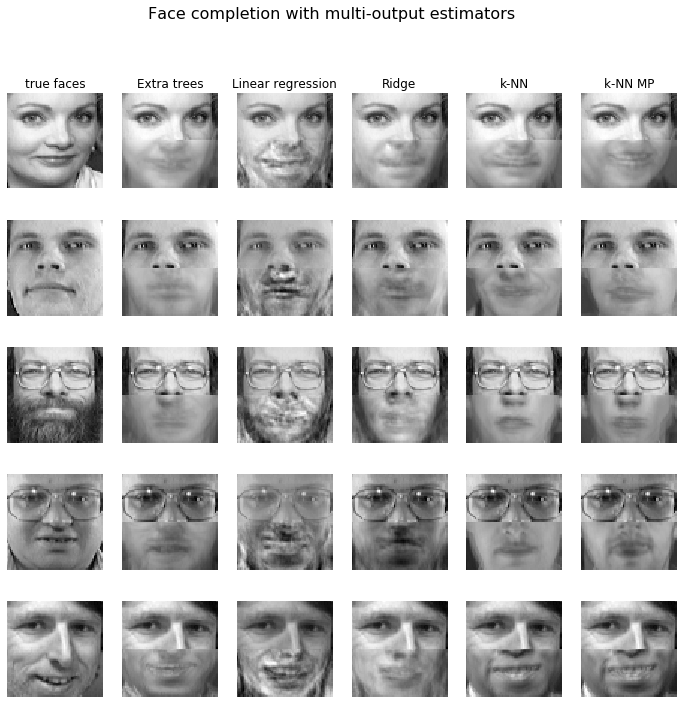

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from hubness.neighbors import KNeighborsRegressor

# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=32,
                                       random_state=0),
    "k-NN": KNeighborsRegressor(weights='distance'),
    "k-NN MP": KNeighborsRegressor(hubness='mp',
                                   hubness_params={'method': 'normal'},
                                   weights='distance'),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()